In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from collections import Counter
from html import unescape
import re
import nltk
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

fetch_spam_data()  # Ensuring data is fetched before proceeding

In [ ]:
#loading all the emails:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]
print("Ham files :", len(ham_filenames))
print("Spam Files :" ,len(spam_filenames))

Ham files : 2500
Spam Files : 500


In [ ]:
# use Python’s email module to parse these emails (this handles headers, encoding, and so on)
import email
import email.policy
def load_email(is_spam, filename, spam_path=SPAM_PATH):
  directory = "spam" if is_spam else "easy_ham"
  with open(os.path.join(spam_path, directory, filename), "rb") as f:
    return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [ ]:
# get a feel of what the data looks like, one example of ham and one example of spam
print(ham_emails[1].get_content().strip())
print(spam_emails[6].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/
Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are loo

In [ ]:
# Some emails are multipart, with images and attachments (which can have their attachments).Look at the various types of structures:
def get_email_structure(email):
  if isinstance(email, str):
    return email
  payload = email.get_payload()
  if isinstance(payload, list):
    return "multipart({})".format(", ".join([
      get_email_structure(sub_email)
      for sub_email in payload
    ]))
  else:
    return email.get_content_type()

from collections import Counter
def structures_counter(emails):
  structures = Counter()
  for email in emails:
    structure = get_email_structure(email)
    structures[structure] += 1
  return structures
structures_counter(ham_emails).most_common()
structures_counter(spam_emails).most_common()


[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [ ]:
# look at the email headers:
for header, value in spam_emails[0].items():
  print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [ ]:
# Subject header
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [ ]:
# Combine ham and spam emails into a single list
all_emails = ham_emails + spam_emails

In [ ]:
##2. Split the datasets into a training set and a test set.
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0]*len(ham_emails) + [1]*len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train: Training emails
# y_train: Corresponding labels for training emails
# X_test: Test emails
# y_test: Corresponding labels for test emails


In [ ]:
##Preprocessing

import re
from html import unescape

#converting HTML to plain text
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

#Veriying code
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [ ]:
#Function that takes an email as input and returns its content as plain text
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)


import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

%pip install -q -U urlextract


import urlextract


url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))


Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls
['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [ ]:
#converting word counts to vectors
from sklearn.base import BaseEstimator, TransformerMixin


class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if not isinstance(text, str):
                print("Warning: Skipping non-string content in email.")
                continue
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size

    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self

    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))



In [ ]:
# Combine the preprocessing steps into a single pipeline
preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])


In [ ]:
# Fit and transform the training data
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
# Transform the test data
X_test_transformed = preprocess_pipeline.transform(X_test)

In [ ]:
# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
nb_classifier = MultinomialNB()
svm_classifier = SVC()

# Create a list of classifiers
classifiers = [rf_classifier, nb_classifier, svm_classifier]



Classifier: RandomForestClassifier
Accuracy: 0.9900

Classifier: MultinomialNB
Accuracy: 0.9867

Classifier: SVC
Accuracy: 0.8867


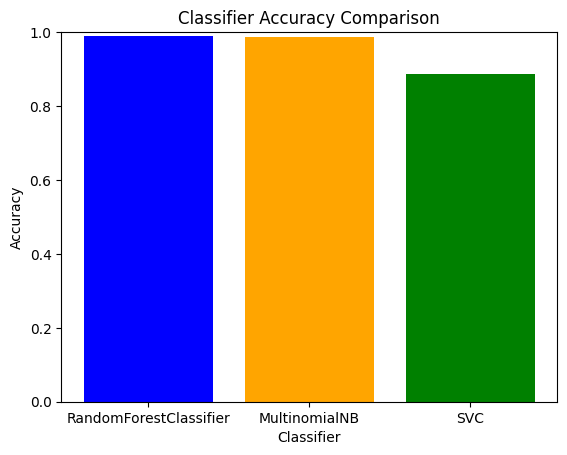

In [ ]:
# Train and evaluate each classifier
accuracy_scores = []
classifiers_names = []

for classifier in classifiers:
    classifier.fit(X_train_transformed, y_train)
    y_pred = classifier.predict(X_test_transformed)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)

    # Print evaluation metrics
    print(f"\nClassifier: {classifier.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")

    # Store results for plotting
    classifiers_names.append(classifier.__class__.__name__)
    accuracy_scores.append(accuracy)

# Plot the accuracy comparison
plt.bar(classifiers_names, accuracy_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for accuracy
plt.show()